# Assignment 4

### 1. 复习上课内容以及复现课程代码

在本部分，你需要复习上课内容和课程代码后，自己复现课程代码。

In [112]:
import numpy as np

class Node:
    # 该类为所有其他图节点的父类
    def __init__(self, inputs=[]):
        # 定义每个节点的输入和输出
        self.inputs = inputs
        self.outputs = []
        
        # 每个节点都是其输入节点的输出节点
        for n in self.inputs:
            n.outputs.append(self)
        
        self.value = None
        
        self.gradients = {}
        
    def forward(self):
        # 前向传播函数 继承该类的其他类会复写该函数
        raise NotImplemented
        
    def backward(self):
        raise NotImplemented

class Input(Node):
    # 输入节点，包括神经网络输入节点，权重节点，和偏差节点
    def __init__(self):
        Node.__init__(self)
    
    def forward(self, value=None):
        # 定义节点数值
        if value is not None:
            self.value = value
    
    def backward(self):
        # 计算节点梯度
        self.gradients = {self:0}
        for n in self.outputs:
            # 以下计算该节点的输出节点对该节点的梯度
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1
            
class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)
    
    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))
        
class Linear(Node):
    # 全连接网络层的计算
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])
    
    def forward(self):
        # 前向传播计算 y = w*x + b
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value
        
        self.value = np.dot(inputs, weights) + bias
        
    def backward(self):
        # 反向传播计算
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}
        for n in self.outputs:
            # Get the partial of the cost w.r.t this node
            grad_cost = n.gradients[self]
            # 以下分别计算对inputs，weights，bias的梯度
            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)
            
class Sigmoid(Node):
    # 定义sigmoid函数
    def __init__(self, node):
        Node.__init__(self, [node])
        
    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))
    
    def forward(self):
        self.x = self.inputs[0].value
        self.value = self._sigmoid(self.x)
    
    def backward(self):
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.inputs[0]] = grad_cost * self.partial

class MSE(Node):
    
    # 定义平均平方误差
    def __init__(self, y, a):
        Node.__init__(self, [y, a])
        
    def forward(self):
        # 前向传播计算
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)
        
        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a
        
        self.value = np.mean(self.diff**2)
        
    def backward(self):
        # 反向计算相应梯度
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff
        
def forward_and_backward(outputnode, graph):
    for n in graph:
        n.forward()
    
    for n in graph[::-1]:
        n.backward()
        
def topological_sort(feed_dict):
    input_nodes = [n for n in feed_dict.keys()]
    
    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)
            
    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]
        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            if len(G[m]['in']) == 0:
                S.add(m)
    return L
    
def sgd_update(trainables, learning_rate=1e-2):
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]

In [19]:
x = np.arange(24).reshape(3, 2, 4)
y = np.mean(x, axis=1)
print(type(x), x)
print(type(y), y)

<class 'numpy.ndarray'> [[[ 0  1  2  3]
  [ 4  5  6  7]]

 [[ 8  9 10 11]
  [12 13 14 15]]

 [[16 17 18 19]
  [20 21 22 23]]]
<class 'numpy.ndarray'> [[ 2.  3.  4.  5.]
 [10. 11. 12. 13.]
 [18. 19. 20. 21.]]


In [113]:
from sklearn.datasets import load_boston
import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample
#from miniflow import *

# Load data
data = load_boston()
losses = []

X_ = data['data']
y_ = data['target']

# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

# Neural network
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 5000

# Total number of examples
m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

# Step 4
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)
        # pdb.set_trace()
        X.value = X_batch
        y.value = y_batch
        
        _ = None
        forward_and_backward(_, graph)
        
        rate = 1e-2
        
        sgd_update(trainables, rate)
        
        loss += graph[-1].value
    
    if i % 100 == 0:
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Total number of examples = 506
Epoch: 1, Loss: 168.817
Epoch: 101, Loss: 6.267
Epoch: 201, Loss: 4.623
Epoch: 301, Loss: 5.409
Epoch: 401, Loss: 4.431
Epoch: 501, Loss: 4.981
Epoch: 601, Loss: 4.812
Epoch: 701, Loss: 4.393
Epoch: 801, Loss: 4.175
Epoch: 901, Loss: 4.378
Epoch: 1001, Loss: 4.354
Epoch: 1101, Loss: 3.262
Epoch: 1201, Loss: 3.862
Epoch: 1301, Loss: 3.695
Epoch: 1401, Loss: 4.270
Epoch: 1501, Loss: 3.652
Epoch: 1601, Loss: 4.037
Epoch: 1701, Loss: 3.893
Epoch: 1801, Loss: 3.910
Epoch: 1901, Loss: 3.520
Epoch: 2001, Loss: 3.803
Epoch: 2101, Loss: 3.647
Epoch: 2201, Loss: 3.431
Epoch: 2301, Loss: 3.555
Epoch: 2401, Loss: 2.925
Epoch: 2501, Loss: 3.029
Epoch: 2601, Loss: 3.152
Epoch: 2701, Loss: 3.456
Epoch: 2801, Loss: 3.197
Epoch: 2901, Loss: 3.260
Epoch: 3001, Loss: 3.754
Epoch: 3101, Loss: 3.367
Epoch: 3201, Loss: 3.101
Epoch: 3301, Loss: 3.388
Epoch: 3401, Loss: 3.486
Epoch: 3501, Loss: 2.734
Epoch: 3601, Loss: 3.464
Epoch: 3701, Loss: 2.843
Epoch: 3801, Loss: 3.027
Epoc

In [ ]:
losses

In [110]:
len(losses)

50

In [79]:
def forward(outputNode, graph):
    for n in graph:
        n.forward()
    return outputNode.value

forward(l2, graph)

array([[30.55760592],
       [17.55160851],
       [49.50239142],
       [21.32092866],
       [20.92264739],
       [19.14517708],
       [20.36236633],
       [15.38620835],
       [24.20614233],
       [17.34886253],
       [14.65083553],
       [20.51381618],
       [13.51129777],
       [22.09757797],
       [49.64593432],
       [20.35026791]])

In [92]:
import matplotlib.pyplot as plt

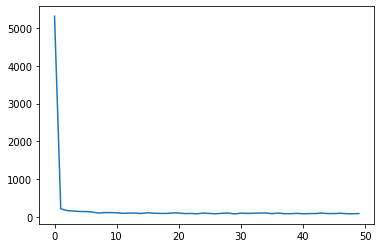

In [111]:
plt.plot(range(len(losses)), losses)

### 2. 回答一下理论题目

#### 1. What does a neuron compute?

就像人类神经细胞一样，神经元可以看作一个计算与存储单元。计算是神经元对其输入进行计算功能；存储是神经元会暂存结果，并传递给下一层
formula:
$$ z = W^Tx + b $$
$$ a = \sigma (z) $$
Activation function like sigmoid, tanh, Relu, Leaky Relu, etc.

####  2. Why we use non-linear activation funcitons in neural networks?

因为如果食用线性激活函数，多个隐藏层其实就可以用一个隐藏层代替, 深度没有了意义

#### 3. What is the 'Logistic Loss' ?

交叉熵在二分类的特殊情况
fomula:
$$ Loss = -ylog\hat y - (1-y)log(1 - \hat y) $$

#### 4. Assume that you are building a binary classifier for detecting if an image containing cats, which activation functions would you recommen using for the output layer ?

A. ReLU    
B. Leaky ReLU    
C. sigmoid    
D. tanh  

C
sigmoid函数取值范围（0，1），适合二分类场景

tanh 效果非常好，几乎适用于所有场合

ReLu 最常用的默认函数，学习速度快

Leaky ReLu 优化版的ReLu


#### 5. Why we don't use zero initialization for all parameters ?

导致神经网络的对称性问题，前向传播值是一样的，反向传播梯度是一样的，无论迭代多少次，loss都不会得到改善, 使神经网络失去意义。解决这个问题的方法就是随机初始化参数

#### 6. Can you implement the softmax function using python ? 

$$ softmax = \frac{e^{z_j}}{{\sum _j^n e^{z_j}}} $$

In [514]:
import numpy as np
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z), axis=0)

In [232]:
a = [[1,2,3,4], [5,5,5,5]]

# print(np.exp(a))

print(np.sum(a, axis=1))

# np.sum(np.exp(a), axis=0)

[10 20]


In [128]:
softmax(a)

array([[3.05799702e-07, 3.05799702e-07, 3.05799702e-07, 3.05799702e-07],
       [3.05799702e-07, 1.12497423e-07, 4.13854892e-08, 1.52248707e-08]])

### 3.实践题

#### In this practical part, you will build a simple digits recognizer to check if the digit in the image is larger than 5. This assignmnet will guide you step by step to finish your first small project in this course .

#### 1 - Packages  
sklearn is a famous package for machine learning.   
matplotlib is a common package for vasualization.

In [396]:
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

#### 2 - Overvie of the dataset  
    - a training set has m_train images labeled as 0 if the digit < 5 or 1 if the digit >= 5
    - a test set contains m_test images labels as if the digit < 5 or 1 if the digit >= 5
    - eah image if of shape (num_px, num_px ). Thus, each image is square(height=num_px and  width = num_px)

In [157]:
# Loading the data 
import numpy as np
digits = datasets.load_digits()

In [ ]:
digits

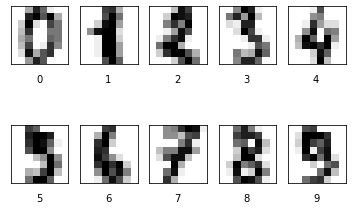

In [132]:
# Vilizating the data
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.imshow(digits.data[i-1].reshape([8,8]),cmap=plt.cm.gray_r)
    plt.text(3,10,str(digits.target[i-1]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [293]:
# Split the data into training set and test set 
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25)

# reformulate the label. 
# If the digit is smaller than 5, the label is 0.
# If the digit is larger than 5, the label is 1.
y_train[y_train < 5 ] = 0
y_train[y_train >= 5] = 1
y_test[y_test < 5] = 0
y_test[y_test >= 5] = 1

# 标准化处理
X_train /= X_train.max()
X_test /= X_train.max()

# 数据格式处理，为了匹配公示
X_train = X_train.T
X_test = X_test.T
y_train = np.expand_dims(y_train, axis=0)
y_test = np.expand_dims(y_test, axis=0)

In [191]:
X_train

array([[ 0.,  0.,  9., ...,  0.,  0.,  0.],
       [ 0.,  2.,  9., ...,  0.,  0.,  0.],
       [ 0.,  0., 10., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  5., ...,  2.,  0.,  0.],
       [ 0.,  0.,  3., ..., 16.,  9.,  0.],
       [ 0.,  0.,  0., ..., 12.,  8.,  0.]])

In [137]:
y_train

array([8, 8, 5, ..., 0, 8, 6])

In [248]:
import numpy as np
r = [[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]]
art = np.array(r)
print(type(ar))
art.shape

<class 'numpy.ndarray'>


(4, 3)

In [235]:
art[1, 2]

6

In [294]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(64, 1347)
(64, 450)
(1, 1347)
(1, 450)


#### 3- Architecture of the neural network

![title](./networks.png)

In [143]:
!pwd

/Users/qinliu/AI/00code/04fourth_class


##### Mathematical expression of the algorithm:

For one example $x^{(i)}$:   
 $$ z^{(i)} = w^T * x^{(i)} +b $$   
 $$ y^{(i)} = a^{(i)} = sigmoid(z^{(i)})$$   
 $$L(a^{(i)},y^{(i)}) = -y^{(i)} log(a^{(i)})-(1-y^{(i)})log(1-a^{(i)})$$

The total cost over all training examples:
$$ J = \frac{1}{m}\sum_{i=1}^{m}L(a^{(i)},y^{(i)}) $$

#### 4 - Building the algorithm

##### 4.1- Activation function    
###### Exercise:
Finish the sigmoid funciton 

In [322]:
def sigmoid(z):
    '''
    Compute the sigmoid of z
    Arguments: z -- a scalar or numpy array of any size.
    
    Return:
    s -- sigmoid(z)
    '''
    s = 1./(1 + np.exp(-1 * z))
    return s

In [152]:
# Test your code 
# The result should be [0.5 0.88079708]
print("sigmoid([0,2]) = " + str(sigmoid(np.array([0,2]))))

[0 2]
<class 'numpy.ndarray'>
[0.5        0.88079708]
sigmoid([0,2]) = [0.5        0.88079708]


##### 4.1-Initializaing parameters
###### Exercise:
Finishe the initialize_parameters function below

In [323]:
# Random innitialize the parameters

def initialize_parameters(dim):
    '''
    Argument: dim -- size of the w vector
    
    Returns:
    w -- initialized vector of shape (dim,1)
    b -- initializaed scalar
    '''
    
    w = np.random.rand(dim, 1)
    b = 0
    
    assert(w.shape == (dim,1))
    assert(isinstance(b,float) or isinstance(b,int))
    
    return w,b

In [212]:
X_train.shape[0]

1347

In [347]:
w1, b1 = initialize_parameters(X_train.shape[0])

In [ ]:
w1, b1

In [217]:
w1.shape

(1347, 1)

#### 4.3-Forward and backward propagation

###### Some mathematical expressions
Forward Propagation:   
. X    
. A = $\sigma(w^T*X+b) = (a^{(1)},a^{(2)},...,a^{(m)}$   
. J = $-\frac{1}{m} \sum_{i=1}^{m}y^{(i)}log(a^{(i)}+(1-y^{(i)})log(1-a^{(i)})$       

Some derivative: 
$$\frac{\partial{J}}{\partial{w}} = \frac{1}{m}X*(A-Y)^T$$   
$$\frac{\partial{J}}{\partial{b}} = \frac{1}{m}\sum_{i=1}^m(a^{(i)}-y^{(i)}) $$

###### Exercise:
Finish the function below:

In [219]:
import pprint

In [383]:
def propagate(w,b,X,Y):
    '''
    Implement the cost function and its gradient for the propagation
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    '''
    m = X.shape[1]
    z = np.dot(w.T, X) + b 
    A = sigmoid(z)
    temp0 = Y * np.log(A)
    temp1 = (1 - Y) * np.log(1 - A)
    
    cost = (-1 / m) * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))
    
    dw = np.dot(X, (A-Y).T) / m
    # print('dw', dw)
    db = np.sum(A-Y) / m
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {'dw':dw,
             'db':db}
    return grads, cost

In [384]:
grads1, cost1 = propagate(w1, b1, X_train, y_train)

In [386]:
cost1

4.800631605060889

##### 4.4 -Optimization

###### Exercise:
Minimizing the cost function using gradient descent.   
$$\theta = \theta - \alpha*d\theta$$ where $\alpha$ is the learning rate.

In [412]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    '''
    This function optimize w and b by running a gradient descen algorithm
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params - dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    '''
    costs = []
    # pdb.set_trace()
    for i in range(num_iterations):
        
        grads, cost = propagate(w, b, X, Y)
        
        dw = grads['dw']
        db = grads['db']
        
        w = w - learning_rate * dw
        b = b - learning_rate * db
        if i % 100 == 0:
            costs.append(cost)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w":w,
              "b":b}
    
    grads = {"dw":dw,
             "db":db}
    
    return params, grads, costs

In [358]:
params1, grads1, cost1 = optimize(w1, b1, X_train, y_train, 4000, 1e-1, print_cost=False)
last_w1 = params1["w"]
last_b1 = params1["b"]

In [379]:
eer = cost1[0]
eer.shape

()

###### Exercise
The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the predict() function.    
Two steps to finish this task:   
1. Calculate $\hat{Y} = A = \sigma(w^T*X+b)$   
2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector Y_prediction. If you wish, you can use an if/else statement in a for loop (though there is also a way to vectorize this).

In [361]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights
    b -- bias 
    X -- data 
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0],1)
    
    A = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        #if A[0,i] <= 0.5:
        #print(A[0, i])
        Y_prediction[0,i] = 0 if A[0,i] <= 0.5 else 1
    
    assert(Y_prediction.shape == (1,m))
    
    return Y_prediction

In [359]:
predict(last_w1, last_b1, X_train)

0.033377013736795046
0.9491875930117785
0.992545713471496
0.01625384432929697
0.8508685658435534
0.10131209158175726
0.37469389483600046
0.008664759761203901
0.009803255578506255
0.8530726068725002
0.9962038548084343
0.671151064185281
0.3030315408729465
0.2120607321274038
0.91803442509936
0.07866398706457638
0.9066942424716905
0.06359756922534039
0.919781621980052
0.11939391064489015
0.9924936520140305
0.24394947450176874
0.7118329703142586
0.6451688169030092
0.06806482734249318
0.00070967699284552
0.9984801070689057
0.7891486382567015
0.24200158037468167
0.7169173560462232
0.9831886852148027
0.11268418134923626
0.987597984859463
0.181147201143048
0.961932012304858
0.6930336299405069
0.3797862909186739
0.017529054717203025
0.9134349261122321
0.8703076676782896
0.02751592873130924
0.3483926822653955
0.9740740436865057
0.9089571168561232
0.9969789837624481
0.820918745457038
0.0034784570803834897
0.2709783560524852
0.014604692603003662
0.7657115097036954
0.9777012562507
0.7155463834831778

array([[0., 1., 1., ..., 0., 1., 1.]])

In [340]:
sef[0, 303]

1.0

##### 5- Merge all functions into a model

Congratulations !! You have finished all the necessary components for constructing a model. Now, Let's take the challenge to merge all the implemented function into one model.

In [392]:
import pdb
def model(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate, print_cost):
    """
    Build the logistic regression model by calling all the functions you have implemented.
    Arguments:
    X_train - training set
    Y_train - training label
    X_test - test set
    Y_test - test label
    num_iteration - hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d - dictionary should contain following information w,b,training_accuracy, test_accuracy,cost
    eg: d = {"w":w,
             "b":b,
             "training_accuracy": traing_accuracy,
             "test_accuracy":test_accuracy,
             "cost":cost}
    """
    # 初始化w，b
    dim = X_train.shape[0]
    w_, b_ = initialize_parameters(dim)
    
    # 训练模型
    params, grads, costs = optimize(w_, b_, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    w = params['w']
    b = params['b']
    
    # 预测
    Y_train_pred = predict(w, b, X_train)
    Y_test_pred = predict(w, b, X_test)
    
    # 计算精确度
    training_accuracy = np.mean(Y_train_pred == Y_train)
    test_accuracy = np.mean(Y_test_pred == Y_test)
    
    # 返回结果
    d = {"w":w,
         "b":b,
         "training_accuracy": training_accuracy,
         "test_accuracy":test_accuracy,
         "cost":costs}
    return d
    

In [297]:
y_train.shape

(1, 1347)

In [401]:
pred = model(X_train, y_train, X_test, y_test, num_iterations=50000, learning_rate=1e-1, print_cost=True)
print(pred)

Cost after iteration 0: 4.615184
Cost after iteration 100: 0.555811
Cost after iteration 200: 0.470154
Cost after iteration 300: 0.424429
Cost after iteration 400: 0.395410
Cost after iteration 500: 0.375023
Cost after iteration 600: 0.359726
Cost after iteration 700: 0.347716
Cost after iteration 800: 0.337970
Cost after iteration 900: 0.329864
Cost after iteration 1000: 0.322990
Cost after iteration 1100: 0.317071
Cost after iteration 1200: 0.311910
Cost after iteration 1300: 0.307361
Cost after iteration 1400: 0.303318
Cost after iteration 1500: 0.299696
Cost after iteration 1600: 0.296430
Cost after iteration 1700: 0.293468
Cost after iteration 1800: 0.290769
Cost after iteration 1900: 0.288298
Cost after iteration 2000: 0.286026
Cost after iteration 2100: 0.283931
Cost after iteration 2200: 0.281992
Cost after iteration 2300: 0.280192
Cost after iteration 2400: 0.278517
Cost after iteration 2500: 0.276954
Cost after iteration 2600: 0.275492
Cost after iteration 2700: 0.274123
Cost

Cost after iteration 23600: 0.240867
Cost after iteration 23700: 0.240854
Cost after iteration 23800: 0.240840
Cost after iteration 23900: 0.240827
Cost after iteration 24000: 0.240814
Cost after iteration 24100: 0.240801
Cost after iteration 24200: 0.240788
Cost after iteration 24300: 0.240776
Cost after iteration 24400: 0.240763
Cost after iteration 24500: 0.240751
Cost after iteration 24600: 0.240738
Cost after iteration 24700: 0.240726
Cost after iteration 24800: 0.240714
Cost after iteration 24900: 0.240702
Cost after iteration 25000: 0.240690
Cost after iteration 25100: 0.240679
Cost after iteration 25200: 0.240667
Cost after iteration 25300: 0.240655
Cost after iteration 25400: 0.240644
Cost after iteration 25500: 0.240633
Cost after iteration 25600: 0.240621
Cost after iteration 25700: 0.240610
Cost after iteration 25800: 0.240599
Cost after iteration 25900: 0.240588
Cost after iteration 26000: 0.240577
Cost after iteration 26100: 0.240567
Cost after iteration 26200: 0.240556
C

Cost after iteration 46900: 0.239363
Cost after iteration 47000: 0.239360
Cost after iteration 47100: 0.239357
Cost after iteration 47200: 0.239353
Cost after iteration 47300: 0.239350
Cost after iteration 47400: 0.239347
Cost after iteration 47500: 0.239343
Cost after iteration 47600: 0.239340
Cost after iteration 47700: 0.239337
Cost after iteration 47800: 0.239333
Cost after iteration 47900: 0.239330
Cost after iteration 48000: 0.239327
Cost after iteration 48100: 0.239323
Cost after iteration 48200: 0.239320
Cost after iteration 48300: 0.239317
Cost after iteration 48400: 0.239314
Cost after iteration 48500: 0.239311
Cost after iteration 48600: 0.239307
Cost after iteration 48700: 0.239304
Cost after iteration 48800: 0.239301
Cost after iteration 48900: 0.239298
Cost after iteration 49000: 0.239295
Cost after iteration 49100: 0.239291
Cost after iteration 49200: 0.239288
Cost after iteration 49300: 0.239285
Cost after iteration 49400: 0.239282
Cost after iteration 49500: 0.239279
C

### 4.选做题

Congratulations on building your first logistic regression model. It is your time to analyze it further.

##### 4.1 Observe the effect of learning rate on the leraning process.   
Hits: plot the learning curve with different learning rate

In [422]:
dict_cost = {}
for lr_i in [4, 0.3, 0.1, 0.05, 0.01, 0.005, 0.001]:
    get_pred = model(X_train, y_train, X_test, y_test, 5000, lr_i, False)
    dict_cost[str(lr_i)] = get_pred['cost']

In [423]:
dict_cost

{'4': [5.060179519338905,
  1.2838817595299268,
  0.28726583427010627,
  1.3984358832664026,
  0.5567114339479535,
  0.31672232318488686,
  0.3018427165768784,
  0.3077034962468226,
  0.35862698480213556,
  0.6713985039923501,
  1.577989371384001,
  0.9373323021787056,
  0.29211285889861077,
  0.26519026080241204,
  0.26449416928017294,
  0.2657016024623213,
  0.2673296079914418,
  0.26935163022718805,
  0.2719152343738305,
  0.27529732921898237,
  0.28004280328316267,
  0.2901463668997807,
  0.6587336778432492,
  1.5502682064841065,
  0.2767538264495546,
  0.2628986525660215,
  0.2641548368352721,
  0.2661348238730461,
  0.26861266917765997,
  0.27181424592542847,
  0.2761887813147167,
  0.28295911989804695,
  0.3819337109586174,
  1.881515355964402,
  0.2909078009211268,
  0.2621442102127242,
  0.26331704972217584,
  0.26537559753970286,
  0.2679563600943864,
  0.2713016631880619,
  0.2758969777210722,
  0.2832303580000402,
  0.4475250453375605,
  1.8475440954874884,
  0.276632986516

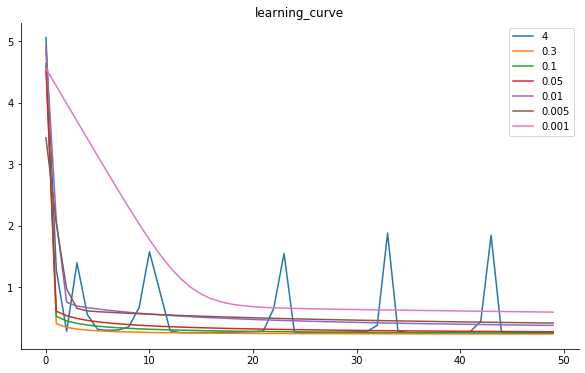

In [456]:
plt.figure(figsize=(10, 6))
for cost_i in dict_cost:
    plt.plot(dict_cost[cost_i], label=cost_i)
    plt.legend(loc="upper right")
    plt.title('learning_curve')
    sns.despine()

Summary: 学习率过大会造成训练速度过快，函数震荡。学习率过小则造成学习则造成训练速度慢，消耗过多时间和空间

##### 4.2 Observe the effect of iteration_num on the test accuracy.

In [438]:
cost_dict = {}
for in_i in [1000, 5000, 10000, 30000, 50000]:
    pred_model = model(X_train, y_train, X_test, y_test, in_i, 1e-2,False)
    cost_dict[str(in_i)] = pred_model['cost']
    print('iteration_num:{}, test_accuracy:{}\n'
          .format(str(in_i), pred_model['test_accuracy']))

iteration_num:1000, test_accuracy:0.5533333333333333

iteration_num:5000, test_accuracy:0.7444444444444445

iteration_num:10000, test_accuracy:0.7888888888888889

iteration_num:30000, test_accuracy:0.8044444444444444

iteration_num:50000, test_accuracy:0.8022222222222222



In [440]:
cost_dict

{'1000': [4.946781035959649,
  2.1383989108018655,
  0.846857025022259,
  0.7775585979318612,
  0.7402453356824378,
  0.7078432079280825,
  0.6794855475932148,
  0.6545393566621196,
  0.6324691620417364,
  0.6128287006191951],
 '5000': [4.729316298541337,
  1.927248489875299,
  0.7102749306907491,
  0.6618657126417963,
  0.6402071426481128,
  0.6205975567600727,
  0.6026922010452637,
  0.5863169779957719,
  0.5713152870427856,
  0.5575462437366863,
  0.5448836216409739,
  0.5332146784933378,
  0.5224389411684142,
  0.5124670056701619,
  0.5032193890400805,
  0.4946254555322084,
  0.4866224288794124,
  0.47915449510332664,
  0.47217199535004134,
  0.4656307050438988,
  0.45949119374967845,
  0.4537182591393046,
  0.44828042808714214,
  0.44314951795721375,
  0.4383002514439342,
  0.43370991877734716,
  0.42935808162975736,
  0.42522631361288027,
  0.4212979728006203,
  0.4175580022322841,
  0.41399275483309184,
  0.41058983962781787,
  0.40733798651775144,
  0.40422692724185555,
  0.401

(-10, 50)

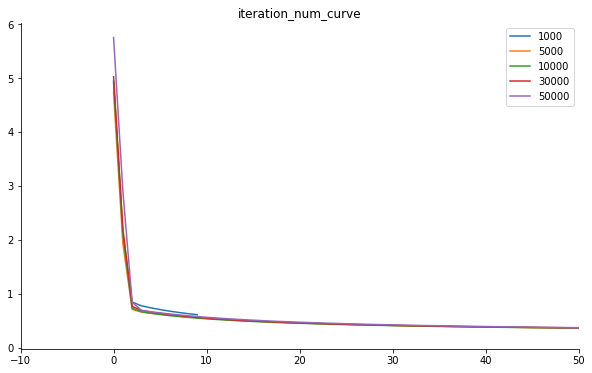

In [462]:
plt.figure(figsize=(10, 6))
for cost_i in cost_dict:
    plt.plot(cost_dict[cost_i], label=cost_i)
    plt.legend(loc="upper right")
plt.title('iteration_num_curve')
sns.despine()
plt.xlim([-10, 50])

Summary：迭代次数过大并不会得到更优的解，会浪费过多资源；迭代次数小会达不到最优解

# Challenge ! ! !

The original data have images labeled 0,1,2,3,4,5,6,7,8,9. In our logistic model, we only detect if the digit in the image is larger or smaller than 5. Now, Let's go for a more challenging problem. Try to use softmax function to build a model to recognize which digit (0,1,2,3,4,5,6,7,8,9) is in the image.

In [482]:
a = np.eye(3)
a = np.eye(3)[[1,2,0,1]]

In [483]:
a

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [474]:
labels = np.array([[1], [2], [0], [1]])

In [475]:
labels.shape

(4, 1)

In [480]:
labels

array([[1],
       [2],
       [0],
       [1]])

In [478]:
res = np.eye(3)[labels.reshape(-1)]

In [481]:
res

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [563]:
# 重写模型方法
def initialize_parameters_1(dim0, dim1):
    dim1 = 1
    w = np.random.rand(dim0, dim1)
    b = 0
    
    assert(w.shape == (dim0, dim1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [485]:
w1, b1 = initialize_parameters_1(64)

In [ ]:
w1, b1

$$ softmax = \frac{e^{z_j}}{{\sum _k e^{z_k}}} $$

$$\frac{d_{cost}}{d_w} = \frac{d_{cost}}{d_A} \frac{d_A}{d_z} \frac{d_z}{d_w} $$

$$\frac{d_{cost}}{d_b} = \frac{d_{cost}}{d_A} \frac{d_A}{d_z} \frac{d_z}{d_b} $$

$$\frac {d_A}{d_z} = softmax(z) - softmax(z)^2 $$

In [ ]:
# Activation Function
def softmax(Z):
    return np.exp(Z) / np.sum(np.exp(Z), axis=0)

In [630]:
def propagate_1(w, b, X, Y):
    m = X.shape[1]
    z = np.dot(w.T, X) + b
    A = softmax(z)
    pdb.set_trace()
    cost = - np.sum(Y * np.log(A))
    print(cost)
    db = np.sum(Y/A) * (A - A * A)
    dw = np.dot(X, db.T)

    print("dbshape", db.shape)
    print("dwshape", dw.shape)
    print("wshape", w.shape)
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {'dw':dw, 'db':db}
    return grads, cost

In [632]:
np.squeeze(11014.097059229767)

array(11014.09705923)

In [625]:
def optimize_1(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    costs = []
    
    for i in range(num_iterations):
        
        grads, cost = propagate_1(w, b, X, Y)
        
        dw = grads['dw']
        db = grads['db']
        
        w = w - learning_rate * dw
        b = b - learning_rate * db
        if i % 100 == 0:
            costs.append(cost)
        if print_cost and i % 100 == 0:
            print("Cost after iteration %i: %f"%(i, cost))
    
    params = {"w":w, "b":b}
    
    grads = {"dw":dw, "db":db}

In [626]:
def predict_1(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights
    b -- bias 
    X -- data 
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    # w = w.reshape(X.shape[0],1)
    
    A = softmax(np.dot(w.T, X) + b)
    
    Y_prediction[0] = A.argmax(axis=0)
    
    assert(Y_prediction.shape == (1,m))
    
    return Y_prediction

In [627]:
import pdb
def model_1(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate, print_cost):
    """
    Build the logistic regression model by calling all the functions you have implemented.
    Arguments:
    X_train - training set
    Y_train - training label
    X_test - test set
    Y_test - test label
    num_iteration - hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d - dictionary should contain following information w,b,training_accuracy, test_accuracy,cost
    eg: d = {"w":w,
             "b":b,
             "training_accuracy": traing_accuracy,
             "test_accuracy":test_accuracy,
             "cost":cost}
    """
    # 初始化w，b
    dim0 = X_train.shape[0]
    dim1 = 1
    #dim1 = X_train.shape[1]
    w_, b_ = initialize_parameters_1(dim0, dim1)
    
    # 训练模型
    params, grads, costs = optimize_1(w_, b_, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    w = params['w']
    b = params['b']
    
    # 预测
    Y_train_pred = predict_1(w, b, X_train)
    Y_test_pred = predict_1(w, b, X_test)
    
    # 计算精确度
    training_accuracy = np.mean(Y_train_pred == Y_train)
    test_accuracy = np.mean(Y_test_pred == Y_test)
    
    # 返回结果
    d = {"w":w,
         "b":b,
         "training_accuracy": training_accuracy,
         "test_accuracy":test_accuracy,
         "cost":costs}
    return d
    

In [628]:
# 获取数据
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25)

# 数据预处理
# X标准化处理
X_train /= X_train.max()
X_test /= X_train.max()
# XY参数格式调整
X_train = X_train.T
y_train = np.eye(10)[y_train].T
X_test = X_test.T
y_test = np.eye(10)[y_test].T

In [492]:
np.eye(10)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [615]:
w, b = initialize_parameters_1(64, 1)
print(w, b)
z = np.dot(w.T, X_train) + b
print(z)
A = softmax(z)
print(A)
#Y_r = Y.reshape(-1,1) 
    
#cost = -Y_r + np.log1p(np.sum(np.exp(A))) 
cost = - np.sum(y_train * np.log(A))

[[0.74317351]
 [0.60055883]
 [0.65461943]
 [0.76359327]
 [0.15956716]
 [0.88160861]
 [0.87668029]
 [0.02421649]
 [0.32189053]
 [0.13551655]
 [0.88053639]
 [0.75045722]
 [0.21091565]
 [0.63473932]
 [0.20629332]
 [0.97637536]
 [0.34446693]
 [0.9384066 ]
 [0.63311313]
 [0.92723755]
 [0.63054893]
 [0.69993758]
 [0.44697037]
 [0.70855111]
 [0.6128139 ]
 [0.80357074]
 [0.3595893 ]
 [0.09918097]
 [0.63670435]
 [0.8955605 ]
 [0.12699385]
 [0.64380256]
 [0.11368422]
 [0.34082435]
 [0.48765533]
 [0.1018142 ]
 [0.77704311]
 [0.74730278]
 [0.1056142 ]
 [0.38555788]
 [0.90261802]
 [0.22676557]
 [0.74799785]
 [0.76162415]
 [0.95612675]
 [0.76945904]
 [0.01590671]
 [0.71970205]
 [0.48223615]
 [0.18731873]
 [0.42352537]
 [0.81413156]
 [0.63568063]
 [0.18177685]
 [0.24847952]
 [0.39971973]
 [0.77704519]
 [0.55654532]
 [0.37523416]
 [0.21441593]
 [0.94924423]
 [0.17710219]
 [0.37120875]
 [0.49433881]] 0
[[13.8268581  12.2547135  12.31028155 ... 12.54696751  9.62442565
  11.06718745]]
[[4.77242158e-03 9.

In [618]:
cost

11014.097059229767

In [633]:
d = model_1(X_train, y_train, X_test, y_test, 1000, 1e-2, False)

> <ipython-input-630-622f9b0dc230>(6)propagate_1()
-> cost = - np.sum(Y * np.log(A))
(Pdb) n
> <ipython-input-630-622f9b0dc230>(7)propagate_1()
-> print(cost)
(Pdb) n
10896.353168299938
> <ipython-input-630-622f9b0dc230>(8)propagate_1()
-> db = np.sum(Y/A) * (A - A * A)
(Pdb) n
> <ipython-input-630-622f9b0dc230>(9)propagate_1()
-> dw = np.dot(X, db.T)
(Pdb) n
> <ipython-input-630-622f9b0dc230>(11)propagate_1()
-> print("dbshape", db.shape)
(Pdb) n
dbshape (1, 1347)
> <ipython-input-630-622f9b0dc230>(12)propagate_1()
-> print("dwshape", dw.shape)
(Pdb) n
dwshape (64, 1)
> <ipython-input-630-622f9b0dc230>(13)propagate_1()
-> print("wshape", w.shape)
(Pdb) n
wshape (64, 1)
> <ipython-input-630-622f9b0dc230>(14)propagate_1()
-> assert(dw.shape == w.shape)
(Pdb) n
> <ipython-input-630-622f9b0dc230>(15)propagate_1()
-> assert(db.dtype == float)
(Pdb) n
> <ipython-input-630-622f9b0dc230>(16)propagate_1()
-> cost = np.squeeze(cost)
(Pdb) n
> <ipython-input-630-622f9b0dc230>(17)propagate_1()
->

/Users/qinliu/AI/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


> <ipython-input-630-622f9b0dc230>(6)propagate_1()
-> cost = - np.sum(Y * np.log(A))
(Pdb) n
> <ipython-input-630-622f9b0dc230>(7)propagate_1()
-> print(cost)
(Pdb) n
nan
> <ipython-input-630-622f9b0dc230>(8)propagate_1()
-> db = np.sum(Y/A) * (A - A * A)
(Pdb) pp Y
array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
(Pdb) pp n.log(A)
*** NameError: name 'n' is not defined
(Pdb) pp A
array([[nan, nan, nan, ..., nan, nan, nan]])
(Pdb) pp z
array([[-1246970.37633179, -1255999.32387255, -1211752.28763501, ...,
         -959126.18360423, -1082846.12006942, -1134018.76997431]])
(Pdb) softmax(z)
array([[nan, nan, nan, ..., nan, nan, nan]])
(Pdb) n
> <ipython-input-630-622f9b0dc230>(9)propagate_1()
-> dw = np.dot(X, db.T)
(Pdb) quit


BdbQuit: 

In [592]:
X1 = np.zeros((64, 1347))
db1 = np.zeros((1, 1347))
test = np.dot(X1, db1.T)
test.shape

(64, 1)

# Congratulations ! You have completed assigment 4. 